# Time-Series Fault Detection Pipeline
**Models:** XGBoost & Random Forest
**Techniques:** ROS, RUS, SMOTE, ADASYN, Optuna Tuning
**Validation:** TimeSeriesSplit

# 1. INSTALLATION & IMPORTS

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import xgboost as xgb
import optuna
import logging
import sys

from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (balanced_accuracy_score, recall_score, f1_score,
                             confusion_matrix, log_loss, precision_score,
                             precision_recall_curve, auc, fbeta_score)
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Mute Optuna logging for cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
# Define the Graphs Style
thesis_params = {
    # Fonts
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 20,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 24,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'savefig.bbox': 'tight',
}

# Apply the settings
plt.rcParams.update(thesis_params)

# Set font size
sns.set_theme(context="paper", style="whitegrid", font_scale=1.5)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Thesis data/Processed_LBNL_dataset.csv', index_col='Datetime', parse_dates=['Datetime'])
df

,CHWC_VLV,MA_TEMP,OA_CFM,OA_DMPR,OA_TEMP,RA_CFM,RA_TEMP,RF_SPD_DM,RF_WAT,SA_SP,...,SA_TEMP_roc_24h,SA_TEMPSPT_roc_24h,SF_SPD_roc_24h,ZONE_TEMP_1_roc_24h,ZONE_TEMP_2_roc_24h,ZONE_TEMP_3_roc_24h,ZONE_TEMP_4_roc_24h,ZONE_TEMP_5_roc_24h,Fault,Intensity
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 02:36:00,9.706668e-23,66.374405,357730.44,0.0,11.569990,0.839995,68.443710,0.0,-2.536799e-13,402.07620,...,-0.000275,0.0,0.0,1.420360,-0.227590,-0.329040,-0.186105,-0.167816,0,0
2018-01-01 02:37:00,-5.625585e-22,66.374405,357730.44,0.0,11.588007,0.839858,68.442240,0.0,-2.535969e-13,402.07617,...,-0.000275,0.0,0.0,1.395540,-0.230280,-0.332229,-0.189024,-0.172150,0,0
2018-01-01 02:38:00,8.612722e-23,66.374405,357730.44,0.0,11.606024,0.839721,68.440735,0.0,-2.535169e-13,402.07614,...,0.000385,0.0,0.0,1.371260,-0.232854,-0.335310,-0.191880,-0.176440,0,0
2018-01-01 02:39:00,2.201429e-23,66.374405,357730.44,0.0,11.623987,0.839584,68.439210,0.0,-2.534343e-13,402.07610,...,-0.000221,0.0,0.0,1.347640,-0.235445,-0.338275,-0.194680,-0.180620,0,0
2018-01-01 02:40:00,-3.758696e-22,66.374405,357730.44,0.0,11.642004,0.839447,68.437670,0.0,-2.533547e-13,402.07608,...,-0.000221,0.0,0.0,1.324570,-0.237900,-0.341190,-0.197370,-0.184730,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:55:00,1.036425e-28,69.257660,357730.44,0.0,21.218018,-0.004739,64.080440,0.0,-8.024693e-18,401.86380,...,0.000000,0.0,0.0,-0.059770,-0.429291,-0.485922,-0.397814,-0.494604,0,0
2018-12-31 23:56:00,5.023776e-25,69.257660,357730.44,0.0,21.185005,-0.004736,64.076380,0.0,-8.061065e-18,401.86380,...,0.000000,0.0,0.0,-0.059875,-0.429456,-0.486526,-0.398090,-0.494553,0,0
2018-12-31 23:57:00,1.209952e-24,69.257660,357730.44,0.0,21.151989,-0.004739,64.072310,0.0,-8.029253e-18,401.86380,...,0.000000,0.0,0.0,-0.059930,-0.429565,-0.487132,-0.398255,-0.494492,0,0


In [6]:
# Column SA_SP is a data leakage.
# The logic behind the faults is based on this feature.
# If this feature is included the model achieves a perfect score
# Thus it is deleted

# Check correlation of the suspicious feature with the Fault
suspicious_feature = 'SA_SP'

# Checking all the rolling features too
cols_to_check = [c for c in df.columns if suspicious_feature in c or 'Fault' in c]

print(df[cols_to_check].corr()['Fault'].sort_values(ascending=False))

Fault               1.000000
SA_SP_var_6h        0.443759
SA_SP_var_24h       0.422408
SA_SP_var_1h        0.328838
SA_SP_max_24h      -0.006989
SA_SP_min_24h      -0.337366
SA_SP_roc_1h       -0.388410
SA_SP_mean_24h     -0.409070
SA_SP_max_6h       -0.523734
SA_SP_min_6h       -0.542561
SA_SP_roc_6h       -0.573037
SA_SP_roc_24h      -0.690398
SA_SP_mean_6h      -0.703086
SA_SP_min_1h       -0.831456
SA_SP_max_1h       -0.841328
SA_SP_mean_1h      -0.908061
SA_SP              -0.999865
SA_SPSPT_max_24h         NaN
Name: Fault, dtype: float64


In [7]:
# Dropping the columns
columns_to_drop = [col for col in df.columns if suspicious_feature in col]

if columns_to_drop:
    print(f"Dropping {len(columns_to_drop)} columns related to '{suspicious_feature}'.")
    df.drop(columns=columns_to_drop, inplace=True)
else:
    print(f"No additional columns related to '{suspicious_feature}' found to drop.")

Dropping 17 columns related to 'SA_SP'.


In [8]:
# @title 2. PREPROCESSING

# 1. Isolate the Target
y = df['Fault']

# 2. Isolate the Metadata for Analysis (Intensity)
if 'Intensity' in df.columns:
    intensity_col = df['Intensity']
else:
    # Fallback if column not found, creates dummy zeros
    print("Warning: 'Intensity' column not found. Creating dummy.")
    intensity_col = pd.Series(0, index=df.index)

# 3. Define Training Features (X)
# Drop Target, and Intensity Label
drop_cols = ['Fault', 'Intensity']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], axis=1)

# 4. Time Series Split (80/20)
split_idx = int(len(df) * 0.8)

# Features
X_train_full, X_test = X.iloc[:split_idx], X.iloc[split_idx:]

# Targets
y_train_full, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Intensity Metadata (For Testing/Plotting only)
intensity_train, intensity_test = intensity_col.iloc[:split_idx], intensity_col.iloc[split_idx:]

print(f"Training set: {X_train_full.shape}")
print(f"Test set:     {X_test.shape}")
print(f"Test Faults:  {y_test.sum()}")
print(f"Test Set Fault Ratio: {y_test.mean():.4f}")

Training set: (417480, 173)
Test set:     (104371, 173)
Test Faults:  1807
Test Set Fault Ratio: 0.0173


# 3. OPTUNA OBJECTIVE FUNCTION


In [9]:
# This function handles the TimeSeriesSplit CV and Hyperparameter search
def objective(trial, model_type, sampler_type, X, y):
    # -- 1. Define Sampler --
    if sampler_type == 'None':
        sampler = None
    elif sampler_type == 'ROS':
        sampler = RandomOverSampler(random_state=42)
    elif sampler_type == 'RUS':
        sampler = RandomUnderSampler(random_state=42)
    elif sampler_type == 'SMOTE':
        sampler = SMOTE(random_state=42)
    elif sampler_type == 'ADASYN':
        # ADASYN can fail on very small datasets/folds if neighbors aren't found
        try:
            sampler = ADASYN(random_state=42)
        except:
            sampler = RandomOverSampler(random_state=42) # Fallback

    # -- 2. Define Model & Hyperparameters --
    if model_type == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
            'tree_method': 'hist',
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'n_jobs': -1,
            'random_state': 42,
            'verbosity': 0
        }
        model = xgb.XGBClassifier(**params)

    elif model_type == 'RandomForest':
        # Tune it based on the logloss score returned to Optuna.
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            # Class weight: None or Balanced (or manual weights)
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
            'n_jobs': -1,
            'random_state': 42
        }
        model = RandomForestClassifier(**params)

    # -- 3. TimeSeries Cross-Validation --
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    # Use ImbPipeline to ensure resampling happens ONLY on the train fold
    # and not on the validation fold
    for train_index, val_index in tscv.split(X):
        X_fold_train, X_fold_val = X.iloc[train_index], X.iloc[val_index]
        y_fold_train, y_fold_val = y.iloc[train_index], y.iloc[val_index]

        if sampler:
          # Scale -> Sample -> Model
          pipeline = ImbPipeline(steps=[
              ('scaler', StandardScaler()),
              ('sampler', sampler),
              ('model', model) # Changed from final_model to model
          ])
        else:
          pipeline = ImbPipeline(steps=[
              ('scaler', StandardScaler()),
               ('model', model) # Changed from final_model to model
          ])

        pipeline.fit(X_fold_train, y_fold_train)

        # Predict probabilities for Log Loss
        preds_proba = pipeline.predict_proba(X_fold_val)[:, 1]

        # Calculate Binary Cross Entropy (Log Loss)
        try:
            score = log_loss(y_fold_val, preds_proba)
        except ValueError:
            # Handle edge case where single class is present in fold
            score = 999

        scores.append(score)

    # Optuna minimizes the objective
    return np.mean(scores)

In [10]:
# @title 4. MAIN EXECUTION LOOP (PR Curve Optimization)

#Configurations
models = ['XGBoost', 'RandomForest']
samplers = ['None', 'ROS', 'RUS', 'SMOTE', 'ADASYN']

best_results_df = pd.DataFrame()
pr_curves_data = {} # To store curve data for plotting
best_params_dict = {}

combinations = [(m, s) for m in models for s in samplers]
pbar = tqdm(combinations, desc="Overall Progress")

print("Starting Training & PR Curve Optimization...")

for model_name, sampler_name in pbar:
    run_name = f"{model_name}_{sampler_name}"
    pbar.set_description(f"Processing: {run_name}")

    # 1. Hyperparameter Search
    sampler = optuna.samplers.TPESampler(seed=42)

    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(lambda t: objective(t, model_name, sampler_name, X_train_full, y_train_full),
                   n_trials=30, show_progress_bar=False)
    best_params = study.best_params

    best_params_dict[run_name] = best_params

    # 2. Train Final Model
    if sampler_name == 'None': sampler = None
    elif sampler_name == 'ROS': sampler = RandomOverSampler(random_state=42)
    elif sampler_name == 'RUS': sampler = RandomUnderSampler(random_state=42)
    elif sampler_name == 'SMOTE': sampler = SMOTE(random_state=42)
    elif sampler_name == 'ADASYN':
        try: sampler = ADASYN(random_state=42)
        except: sampler = RandomOverSampler(random_state=42)

    if model_name == 'XGBoost':
        clf = xgb.XGBClassifier(**best_params, tree_method='hist', objective='binary:logistic', eval_metric='logloss', n_jobs=-1, random_state=42)
    else:
        clf = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)

    pipeline = ImbPipeline(steps=[('scaler', StandardScaler()), ('sampler', sampler), ('model', clf)] if sampler
                           else [('scaler', StandardScaler()), ('model', clf)])

    pipeline.fit(X_train_full, y_train_full)

    # 3. Predict Probabilities
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # 4. FIND OPTIMAL THRESHOLD via PR Curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

    # --- CHANGE: CALCULATE F-BETA INSTEAD OF F1 ---
    beta = 2.0  #

    numerator = (1 + beta**2) * (precisions * recalls)
    denominator = (beta**2 * precisions) + recalls

    # Handle division by zero (if precision+recall = 0)
    fbeta_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)

    # Find index of Max F-Beta
    best_idx = np.argmax(fbeta_scores)

    # Corresponding metrics
    best_score = fbeta_scores[best_idx] # This is now F2, not F1
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]

    # 5. Generate Final Predictions using Optimal Threshold
    y_pred_opt = (y_prob >= best_thresh).astype(int)

    # Store Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()

    # Save Results
    best_results_df = pd.concat([best_results_df, pd.DataFrame({
        'Model': [model_name], 'Sampler': [sampler_name], 'Run_ID': [run_name],
        'Optimal_Threshold': [best_thresh], 'Max_F2': [best_score],
        'Precision': [best_precision], 'Recall': [best_recall],
        'TP': [tp], 'TN': [tn], 'FP': [fp], 'FN': [fn]
    })], ignore_index=True)


    # Store full curve for final plotting
    pr_curves_data[run_name] = {
        'precision': precisions,
        'recall': recalls,
        'auc': auc(recalls, precisions),
        'y_prob': y_prob # Store y_prob here
    }

print("\nProcessing Complete.")

Overall Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Starting Training & PR Curve Optimization...

Processing Complete.


# 6. Reporting model performances (only best threshold)


=== FINAL RESULTS (Optimized by Max F2 on PR Curve) ===
          Model Sampler  Optimal_Threshold    Max_F2    Recall  Precision    TP   FN
0       XGBoost    None           0.262305  0.847666  0.840066   0.879490  1518  289
1       XGBoost     ROS           0.370173  0.813547  0.849474   0.695830  1535  272
2       XGBoost     RUS           0.769836  0.709940  0.723298   0.661103  1307  500
3       XGBoost   SMOTE           0.767351  0.815480  0.804649   0.861885  1454  353
4       XGBoost  ADASYN           0.184031  0.839562  0.857775   0.773839  1550  257
5  RandomForest    None           0.209404  0.765850  0.819590   0.606719  1481  326
6  RandomForest     ROS           0.204119  0.775523  0.828998   0.616461  1498  309
7  RandomForest     RUS           0.528590  0.676008  0.760930   0.467369  1375  432
8  RandomForest   SMOTE           0.299010  0.770310  0.820697   0.618432  1483  324
9  RandomForest  ADASYN           0.345638  0.707847  0.764804   0.545383  1382  425

Plottin

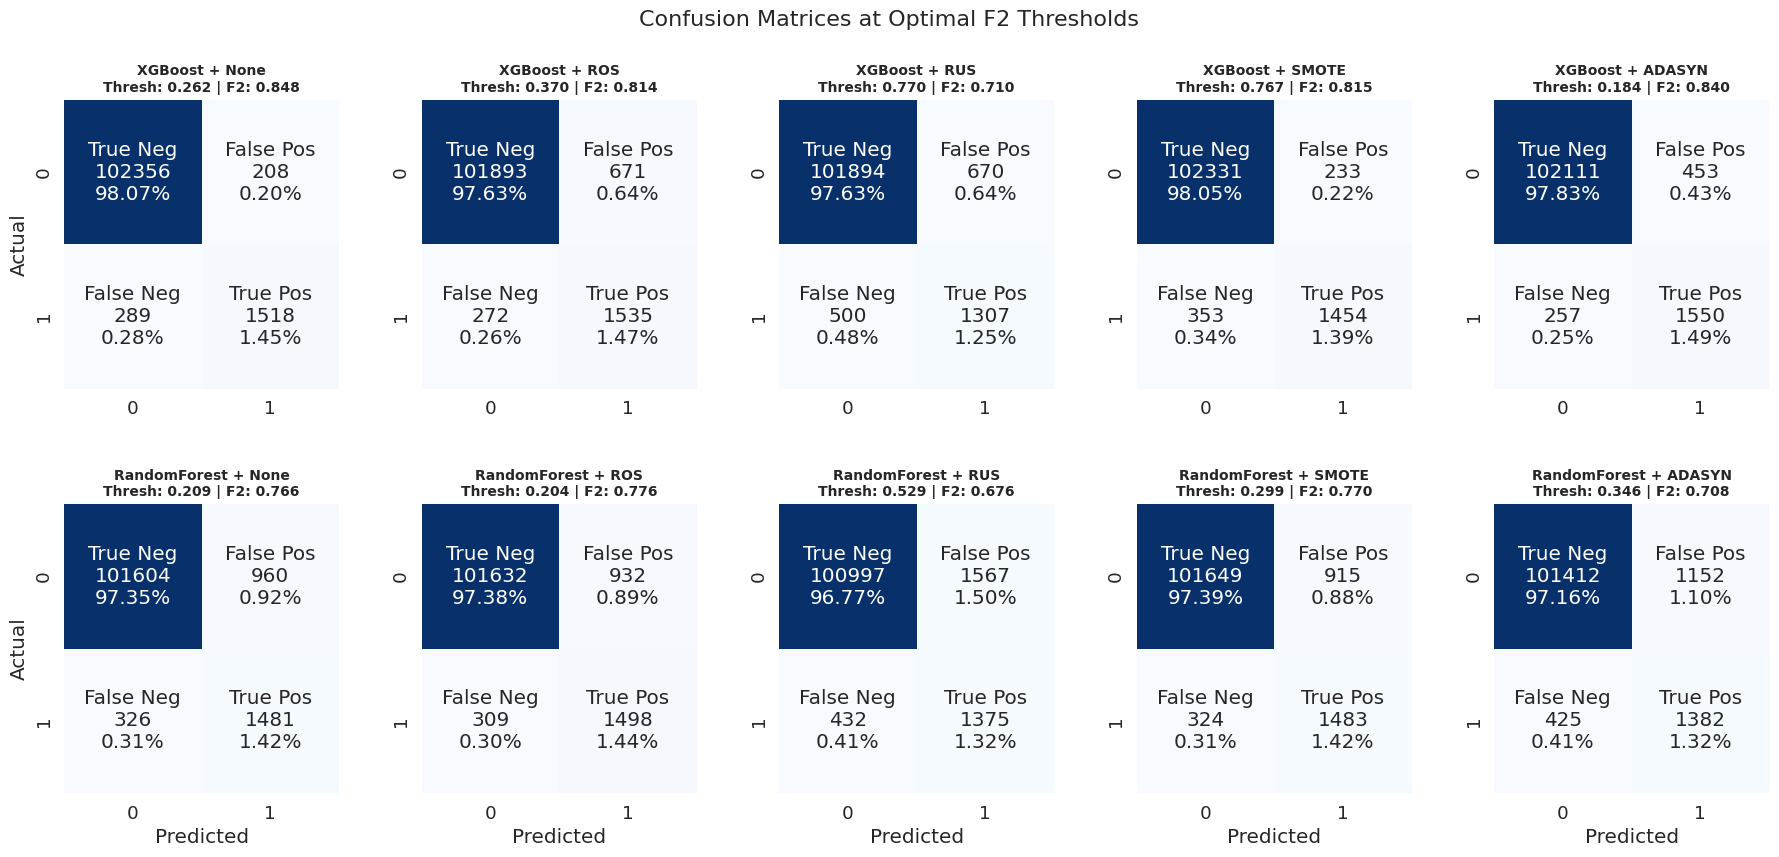

In [11]:
# @title 7. REPORTING (Tables & Confusion Matrix Grid)

# Logical Sorting
model_order = ['XGBoost', 'RandomForest']
sampler_order = ['None', 'ROS', 'RUS', 'SMOTE', 'ADASYN']
best_results_df['Model'] = pd.Categorical(best_results_df['Model'], categories=model_order, ordered=True)
best_results_df['Sampler'] = pd.Categorical(best_results_df['Sampler'], categories=sampler_order, ordered=True)
logical_df = best_results_df.sort_values(by=['Model', 'Sampler'])

print("\n=== FINAL RESULTS (Optimized by Max F2 on PR Curve) ===")
print(logical_df[['Model', 'Sampler', 'Optimal_Threshold', 'Max_F2', 'Recall', 'Precision', 'TP', 'FN']]
      .reset_index(drop=True).to_string())

# --- PLOT 1: Confusion Matrix Grid ---
print("\nPlotting Confusion Matrices (At Optimal Thresholds)...")
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(22, 9))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axes_flat = axes.flatten()

for i, (model, sampler) in enumerate([(m, s) for m in model_order for s in sampler_order]):
    ax = axes_flat[i]
    row = best_results_df[(best_results_df['Model'] == model) & (best_results_df['Sampler'] == sampler)].iloc[0]

    cm_matrix = np.array([[int(row['TN']), int(row['FP'])], [int(row['FN']), int(row['TP'])]])

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm_matrix.flatten()/np.sum(cm_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"{model} + {sampler}\nThresh: {row['Optimal_Threshold']:.3f} | F2: {row['Max_F2']:.3f}", fontsize=10, fontweight='bold')
    if i % 5 == 0: ax.set_ylabel('Actual')
    if i >= 5: ax.set_xlabel('Predicted')

plt.suptitle("Confusion Matrices at Optimal F2 Thresholds", fontsize=16)
plt.savefig("Confusion Matrices LBNL.pdf")
plt.show()


Plotting Combined Precision-Recall Curves...


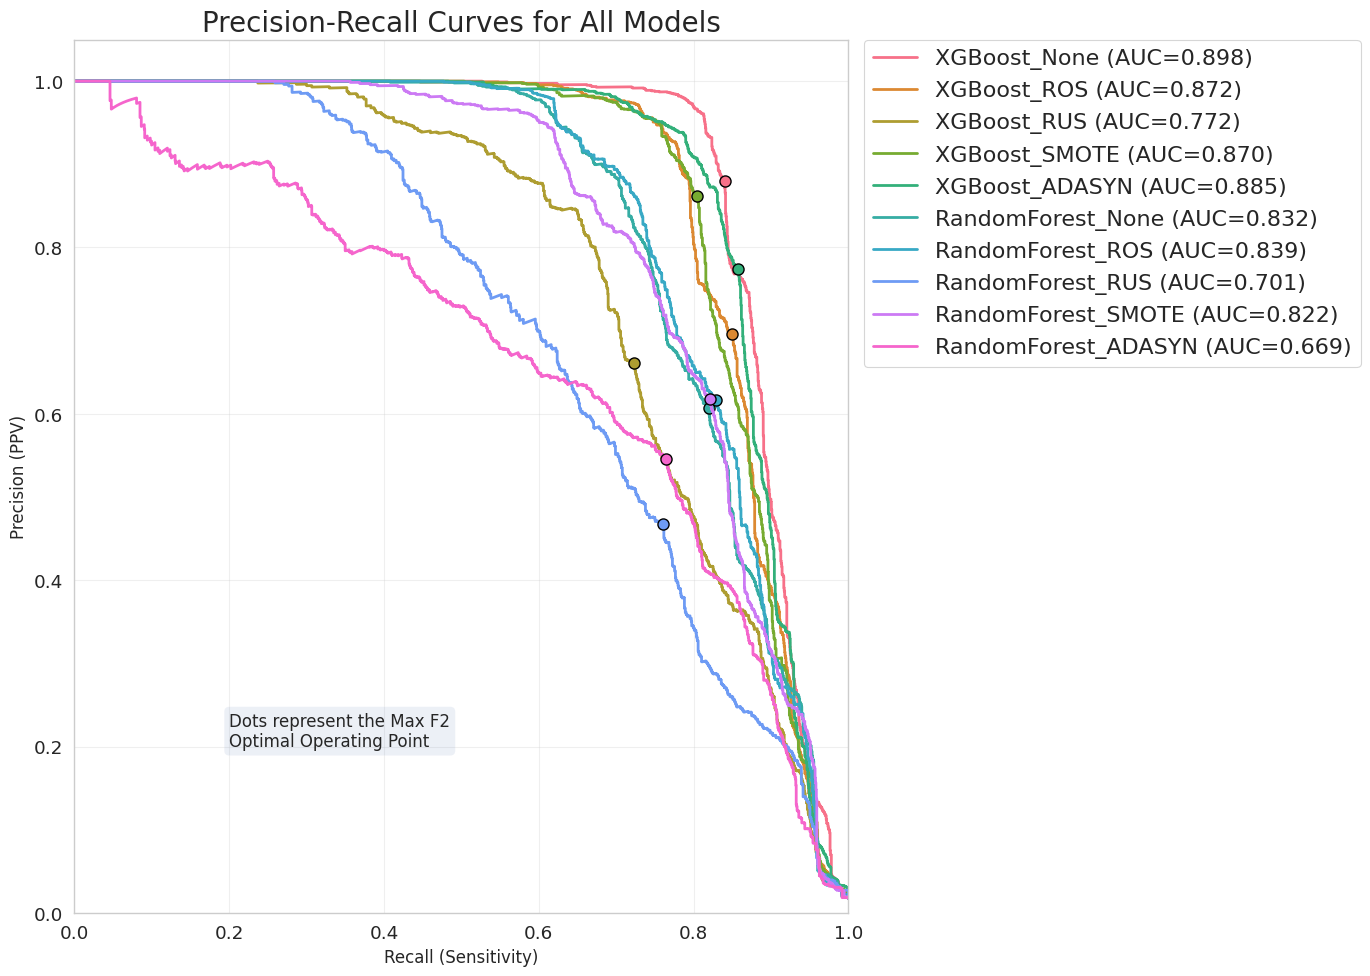

In [12]:
# @title 8. PLOT 2: COMBINED PRECISION-RECALL CURVE
print("\nPlotting Combined Precision-Recall Curves...")
plt.figure(figsize=(14, 10))

# Define colors/markers for distinction
colors = sns.color_palette("husl", 10)
lines = []

for i, (run_name, data) in enumerate(pr_curves_data.items()):
    # Get model specifics for legend
    auc_score = data['auc']
    p, r = data['precision'], data['recall']

    # Plot line
    l, = plt.plot(r, p, color=colors[i], lw=2, label=f'{run_name} (AUC={auc_score:.3f})')
    lines.append(l)

    # Mark the Optimal Point (Max F2)
    # We find the specific point in the saved df
    row = best_results_df[best_results_df['Run_ID'] == run_name].iloc[0]
    plt.plot(row['Recall'], row['Precision'], marker='o', color=colors[i], markersize=8, markeredgecolor='black')

plt.title('Precision-Recall Curves for All Models', fontsize=20)
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision (PPV)', fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add explanation annotation
plt.text(0.2, 0.2, "Dots represent the Max F2\nOptimal Operating Point",
         fontsize=12, bbox=dict(boxstyle="round", alpha=0.1))

plt.tight_layout()
plt.savefig("PR LBNL.pdf")
plt.show()

Analyzing Intensity Performance for Best Model: XGBoost_None
Threshold: 0.26230481266975403

--- Detection Rate (Recall) by Intensity ---
Abs_Intensity
1    87.274549
2    79.975278
Name: Predicted, dtype: float64


/tmp/ipython-input-2828278820.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=intensity_performance.index, y=intensity_performance.values, palette="viridis")


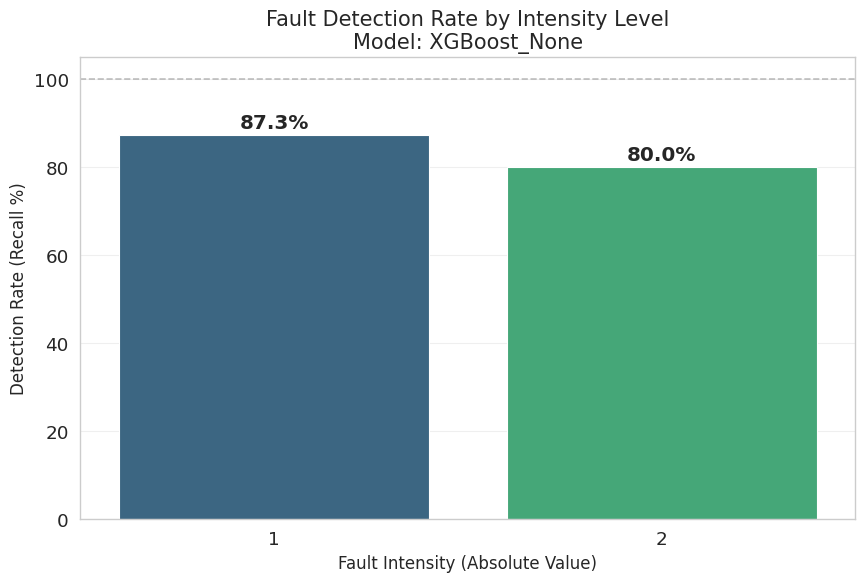

In [13]:
# @title 9. Performance by Fault Intensity
import matplotlib.ticker as mtick

# 1. Retrieve the Best Model's Predictions
best_row_idx = best_results_df['Max_F2'].idxmax()
best_run_name = best_results_df.loc[best_row_idx]['Run_ID']
best_threshold = best_results_df.loc[best_row_idx]['Optimal_Threshold']

print(f"Analyzing Intensity Performance for Best Model: {best_run_name}")
print(f"Threshold: {best_threshold}")

# Get probabilities from stored artifacts
y_prob = pr_curves_data[best_run_name]['y_prob'] # Corrected to use pr_curves_data
y_pred = (y_prob >= best_threshold).astype(int)

# 2. Create Analysis DataFrame
# Combine Actual Labels, Predictions, and the Hidden Intensity Values
analysis_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Raw_Intensity': intensity_test.values
})

# Filter: We only care about rows where a Fault actually existed (Actual == 1)
# We want to see how many of these we successfully caught.
fault_data = analysis_df[analysis_df['Actual'] == 1].copy()

# 3. Handle Absolute Intensity
# We treat -2 and 2 as the same "Level 2" intensity, and -1 and 1 as "Level 1"
fault_data['Abs_Intensity'] = fault_data['Raw_Intensity'].abs()

# 4. Calculate Recall per Intensity Level
# Recall = (Predicted True / Total Actual True) for each group
intensity_performance = fault_data.groupby('Abs_Intensity')['Predicted'].mean() * 100

print("\n--- Detection Rate (Recall) by Intensity ---")
print(intensity_performance)

# 5. Plotting
plt.figure(figsize=(10, 6))

# Create bar plot
ax = sns.barplot(x=intensity_performance.index, y=intensity_performance.values, palette="viridis")

# Styling
plt.title(f"Fault Detection Rate by Intensity Level\nModel: {best_run_name}", fontsize=15)
plt.xlabel("Fault Intensity (Absolute Value)", fontsize=12)
plt.ylabel("Detection Rate (Recall %)", fontsize=12)
plt.ylim(0, 105) # Add some headroom
plt.axhline(y=100, color='grey', linestyle='--', alpha=0.5)

# Add percentage labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.savefig("Performance by Fault Intensity LBNL.pdf")
plt.show()

WINNING MODEL: XGBoost_None
Performance (F2): 0.8477
Retraining winner for feature extraction...


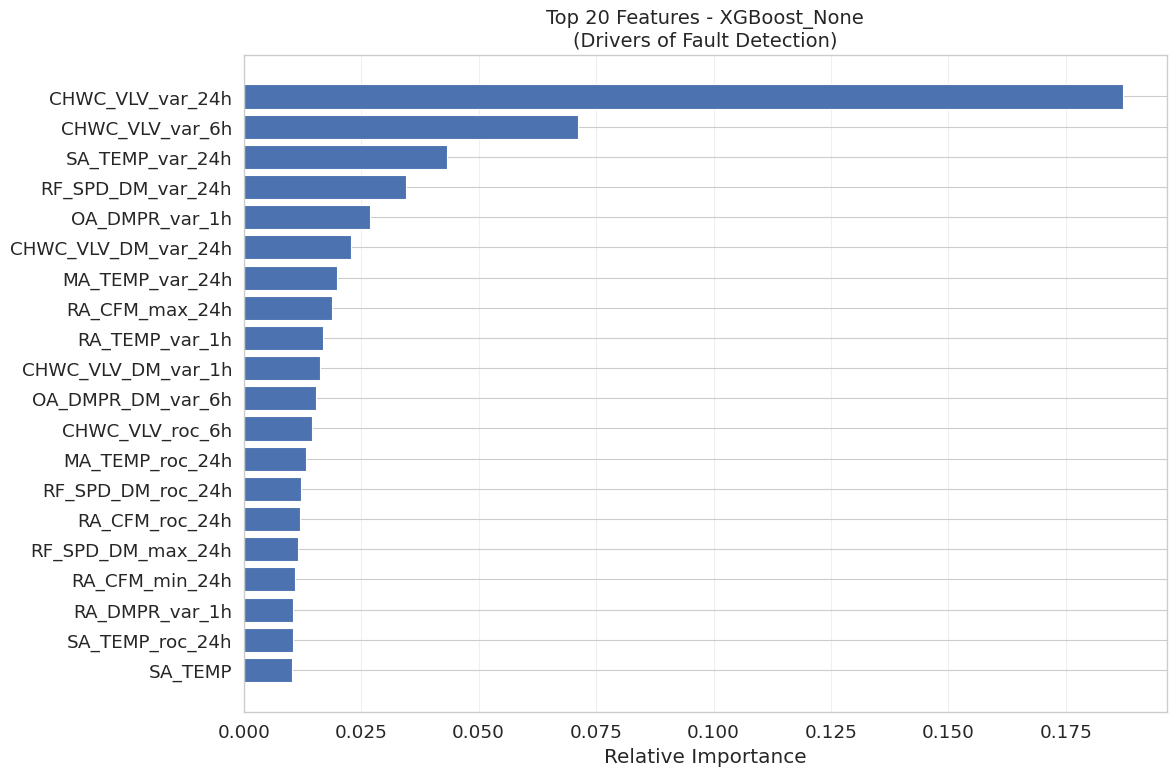


--- INTERPRETATION ---
The most dominant feature is 'CHWC_VLV_var_24h'.
This indicates the raw sensor value is the primary indicator.


In [14]:
# @title 9. FEATURE IMPORTANCE ANALYSIS (Top 20 of Winning Model)

# Identify the Winning Model (Highest F-Beta Score)
# We sort by the specific metric we optimized for (Max_F2)
best_row = best_results_df.sort_values(by=f'Max_F2', ascending=False).iloc[0]

winner_name = best_row['Run_ID']
winner_model_type = best_row['Model']
winner_sampler = best_row['Sampler']
winner_score = best_row[f'Max_F2']

print(f"WINNING MODEL: {winner_name}")
print(f"Performance (F2): {winner_score:.4f}")

# Retrieve Optimal Hyperparameters
# (Assumes best_params_dict was populated in the training loop)
try:
    params = best_params_dict[winner_name]
except KeyError:
    print("Error: 'best_params_dict' not found or empty. Please ensure you saved params in the loop.")
    # Fallback to default params if necessary just to show the plot
    params = {'n_estimators': 100, 'max_depth': 5}

# Re-instantiate the Model & Sampler
if winner_model_type == 'XGBoost':
    clf = xgb.XGBClassifier(**params, tree_method='hist', objective='binary:logistic',
                            eval_metric='logloss', n_jobs=-1, random_state=42)
else:
    clf = RandomForestClassifier(**params, n_jobs=-1, random_state=42)

# Select Sampler
if winner_sampler == 'None': sampler = None
elif winner_sampler == 'ROS': sampler = RandomOverSampler(random_state=42)
elif winner_sampler == 'RUS': sampler = RandomUnderSampler(random_state=42)
elif winner_sampler == 'SMOTE': sampler = SMOTE(random_state=42)
elif winner_sampler == 'ADASYN':
    try: sampler = ADASYN(random_state=42)
    except: sampler = RandomOverSampler(random_state=42)

# Fit the Model (Recalculating on Full Train Data)
# We handle scaling/sampling manually here to keep track of column names
print("Retraining winner for feature extraction...")

X_temp = X_train_full.copy()
y_temp = y_train_full.copy()

# Scale
scaler = StandardScaler()
X_temp_scaled = scaler.fit_transform(X_temp)
# Keep column names! (StandardScaler returns numpy array)
X_temp_df = pd.DataFrame(X_temp_scaled, columns=X_temp.columns)

# Sample
if sampler:
    X_res, y_res = sampler.fit_resample(X_temp_df, y_temp)
else:
    X_res, y_res = X_temp_df, y_temp

# Fit
clf.fit(X_res, y_res)

# Extract Feature Importances
importances = clf.feature_importances_
feature_names = X_train_full.columns

# Sort indices by importance (High to Low)
indices = np.argsort(importances)[::-1]

# Slice Top 20
top_n = 20
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_names = [feature_names[i] for i in top_indices]

# Plotting
plt.figure(figsize=(12, 8))
# Invert y-axis for "Top to Bottom" look
plt.barh(range(top_n), top_importances, color='#4c72b0', align='center')
plt.yticks(range(top_n), top_names)
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance')
plt.title(f'Top {top_n} Features - {winner_name}\n(Drivers of Fault Detection)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("Feature Importance LBNL.pdf")
plt.show()

# Interpretation Text
print("\n--- INTERPRETATION ---")
print(f"The most dominant feature is '{top_names[0]}'.")
if "RoC" in top_names[0]:
    print("This indicates that the RATE OF CHANGE (sudden drops/spikes) is more critical than the absolute value.")
elif "mean" in top_names[0]:
    print("This indicates that the SUSTAINED LEVEL (Rolling Mean) is the primary fault indicator.")
else:
    print("This indicates the raw sensor value is the primary indicator.")